In [ ]:
import numpy as np
import pandas as pd

import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import imutils

import os

In [ ]:
## Ne garder que les images câblées

liste_path_cablees=[]
dossier="D:/Documents/MINES/Info/projet_cern/ModulePictures"

for fichier in os.listdir(dossier):
    if os.path.isfile(os.path.join(dossier, fichier)) and ("AfterBonding" in os.path.basename(fichier)):
        liste_path_cablees.append(str(dossier + "/"+ os.path.basename(fichier)))

liste_images_cablees=[plt.imread(image) for image in liste_path_cablees]


liste_path_non_cablees=[]
dossier="D:/Documents/MINES/Info/projet_cern/ModulePictures"

for fichier in os.listdir(dossier):
    if os.path.isfile(os.path.join(dossier, fichier)) and ("Reception" in os.path.basename(fichier)):
        liste_path_non_cablees.append(str(dossier + "/"+ os.path.basename(fichier)))

liste_images_non_cablees=[plt.imread(image) for image in liste_path_non_cablees]



In [ ]:
## Fonctions utiles

def norme(pix):
    return np.sqrt((pix[0]/255)**2+(pix[1]/255)**2+(pix[2]/255)**2)

def tourner_image(image, pente):
    return imutils.rotate(image, np.arctan(pente))

def trouver_la_paire(fichier, dossier):
    bname=os.path.basename(fichier)
    if "After" in bname:
        name=bname[:bname.find("After")]
        for f in os.listdir(dossier):
            if "Reception" in os.path.basename(f):
                if os.path.basename(f)[:os.path.basename(f).find("Reception")]==name:
                    return f
    elif "Reception" in bname:
        name=bname[:bname.find("Reception")]
        for f in os.listdir(dossier):
            if "After" in os.path.basename(f):
                if os.path.basename(f)[:os.path.basename(f).find("After")]==name:
                    return f
    return "Pas de paire"

In [ ]:
trouver_la_paire("D:/Documents/MINES/Info/projet_cern/ModulePictures/P1011_20UPGM23210962_AfterWirebonding_NOK","D:/Documents/MINES/Info/projet_cern/ModulePictures")

---
## Trouver la colonne verte

### Sans binary : ça marche

In [ ]:
## Trouver la colonne verte v2 gauche

def find_colonne_v2_gauche(image):
    colonnes=[image[:,i,:] for i in range(image.shape[1])]
    i=0
    bool=False
    while not bool and i<len(colonnes)-1:
        col=colonnes[i]
        cpt=0
        for pix in col:
            if (40<pix[0]<100) and (40<pix[1]<100) and  (pix[2]<20):
                cpt+=1       
        if cpt>0.1*image.shape[1]:
            bool=True
        if not bool:
            i+=1
    return i, colonnes[i]


In [ ]:
## Test

for i,im in enumerate(liste_images_cablees):
    print(f"Colonne {find_colonne_v2_gauche(im)[0]}")
    plt.scatter(find_colonne_v2_gauche(im)[0], 0, color='tab:red', marker='+', s=300)
    plt.title(f'Image {i}')
    plt.imshow(im)
    plt.show()

In [ ]:
## Trouver la colonne verte v2 droite

def find_colonne_v2_droite(image):
    colonnes=[image[:,i,:] for i in range(image.shape[1])]
    i=0
    bool=False
    while not bool and i<len(colonnes)-1:
        col=colonnes[image.shape[1]-i-1]
        cpt=0
        for pix in col:
            if (30<pix[0]<100) and (30<pix[1]<100) and  (pix[2]<20):
                cpt+=1       
        if cpt>0.1*image.shape[1]:
            bool=True
        if not bool:
            i+=1
    return image.shape[1]-i-1, col

In [ ]:
## Test

for i,im in enumerate(liste_images_cablees):
    print(f"Colonne {find_colonne_v2_droite(im)[0]}")
    plt.scatter(find_colonne_v2_droite(im)[0], 0, color='tab:red', marker='+', s=300)
    plt.title(f'Image {i}')
    plt.imshow(im)
    plt.show()

In [44]:
## Trouver la ligne verte v2 haute

def find_ligne_v2_haute(image):
    lignes=[image[i,:,:] for i in range(image.shape[0])]
    i=0
    bool=False
    while not bool and i<len(lignes)-1:
        lin=lignes[i]
        cpt=0
        for pix in lin:
            if (30<pix[0]<100) and (30<pix[1]<100) and  (pix[2]<20):
                cpt+=1       
        if cpt>0.1*image.shape[0]:
            bool=True
        if not bool:
            i+=1
    return i, lin

In [45]:
## Trouver la ligne verte v2 basse

def find_ligne_v2_basse(image):
    lignes=[image[i,:,:] for i in range(image.shape[0])]
    i=0
    bool=False
    while not bool and i<len(lignes)-1:
        lin=lignes[image.shape[0]-i-1]
        cpt=0
        for pix in lin:
            if (30<pix[0]<100) and (30<pix[1]<100) and  (pix[2]<20):
                cpt+=1       
        if cpt>0.1*image.shape[0]:
            bool=True
        if not bool:
            i+=1
    return image.shape[0]-i-1, lin

---
## Détection de cercles et de contours

In [ ]:
## Récupérer les carrés contenant la mire 

def carre_mire(image):
    col=find_colonne_v2_gauche(image)[0]
    return image[200:500,250:550,:]

In [ ]:
##  Détection de cercles

for path in liste_path_non_cablees[:2] :
    #Lecture de l'image en noir et blanc
    img = cv.imread(path, cv.IMREAD_GRAYSCALE)
    assert img is not None, "file could not be read, check with os.path.exists()"

    ## TODO : changer cette extraction à la main par quelque chose d'automatisé
    img = img[100:400,300:600]

    #Blur pour réduire le bruit
    img = cv.medianBlur(img,5)
    cimg = cv.cvtColor(img,cv.COLOR_GRAY2BGR)

    #FOnction qui détecte les cercles. minDist = 1e5 pour s'assurer qu'il n'en détecte qu'un => il ne faut qu'un cercle sur l'image.
    circles = cv.HoughCircles(img,cv.HOUGH_GRADIENT,1,minDist = 1e5,
                                param1=50,param2=20,minRadius=20,maxRadius=30)

    #Dessin des cercles
    circles = np.uint16(np.around(circles))
    for i in circles[0,:]:
        cv.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
        cv.circle(cimg,(i[0],i[1]),2,(0,0,255),3)

    cv.imshow('detected circles',cimg)
    cv.waitKey(0)
    cv.destroyAllWindows()

In [ ]:
# Charger l'image
i=0
image_lue=liste_images_cablees[i]
col=find_colonne_v2_gauche(image_lue)[0]
path=liste_path_cablees[i]

image=cv.imread(path)
#gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

# Appliquer un flou pour réduire le bruit
blurred = cv.GaussianBlur(image, (5, 5), 0)

# Détecter les contours avec Canny
edges = cv.Canny(blurred, 50, 150)

# Trouver les contours
contours, _ = cv.findContours(edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

for contour in contours:
    # Approximation des contours pour simplifier les formes
    epsilon = 0.02 * cv.arcLength(contour, True)
    approx = cv.approxPolyDP(contour, epsilon, True)

    # Dessiner les contours détectés
    cv.drawContours(blurred, [approx], -1, (255, 0, 0), 2)

    # Identifier les formes en fonction du nombre de sommets
    if len(approx) == 4:
        # Vérifier si c'est un carré ou un rectangle
        x, y, w, h = cv.boundingRect(approx)

    # Ajouter le nom de la forme sur l'image
    x, y = approx[0][0]
# Afficher l'image avec les formes détectées
plt.imshow(blurred)
plt.show()

In [ ]:
img = cv.imread(liste_path_cablees[5])

lower_bound = np.array([0, 0, 0])
upper_bound = np.array([255,70,70])
imagemask = cv.inRange(img, lower_bound, upper_bound)
imagemask = cv.medianBlur(imagemask,9)

# Trouver les contours
contours, _ = cv.findContours(imagemask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Parcourir les contours pour détecter les carrés
for contour in contours:
    # Approximation du contour
    epsilon = 0.02 * cv.arcLength(contour, True)
    approx = cv.approxPolyDP(contour, epsilon, True)

    # Vérifier si c'est un carré (4 côtés et une aire significative)
    if len(approx) == 4 :
        # Vérifier si les côtés sont à peu près égaux
        (x, y, w, h) = cv.boundingRect(approx)
        aspect_ratio = float(w) / h
        if 0.9 <= aspect_ratio <= 1.1:  # Aspect ratio proche de 1 pour un carré
            # Dessiner le contour du carré
            cv.drawContours(img, [approx], -1, (0, 255, 0), 10)


screen_res = 1280, 720
scale_width = screen_res[0] / img.shape[1]
scale_height = screen_res[1] / img.shape[0]
scale = min(scale_width, scale_height)
window_width = int(img.shape[1] * scale)
window_height = int(img.shape[0] * scale)

cv.namedWindow('title', cv.WINDOW_NORMAL)
cv.resizeWindow('title', window_width, window_height)
cv.imshow('title',img)
cv.waitKey(0)
cv.destroyAllWindows()

---
## Inutile

In [ ]:
img = cv.imread(liste_path_cablees[0], cv.IMREAD_GRAYSCALE)
cimg = cv.cvtColor(img,cv.COLOR_GRAY2BGR)

# Slicing manuel : à changer si possible
dec_g=1000
dec_d=-1000
dec_h=500
dec_b=-500
mask = cv.medianBlur(img[dec_h:dec_b,dec_g:dec_d],25)
cimg = cv.cvtColor(img,cv.COLOR_GRAY2BGR)

#Fonction qui détecte les cercles.
circles = cv.HoughCircles(mask,cv.HOUGH_GRADIENT,1,minDist = 800,
            param1=50,param2=25,minRadius=400 ,maxRadius=420)

circles = np.uint16(np.around(circles))
for i in circles[0,:4]:
    # draw the outer circle
    #cv.circle(cimg,(i[0]+1000,i[1]+500),i[2],(0,255,0),200)
    # draw the center of the circle
    cv.circle(img,(i[0]+1000,i[1]+500),2,(255,0,0),100)

img=liste_images_cablees[0]
print(f"Colonne {find_colonne_v2_gauche(img)[0]}")
plt.imshow(img)
plt.scatter(int(find_colonne_v2_gauche(img)[0]), 0, color='tab:red', marker='+', s=300)
plt.title('Image originale')
plt.show()

cercles_haut=[]
cercles_bas=[]
for cercle in circles[0,:4]:
    if cercle[1]>cimg.shape[0]/2:
        cercles_bas.append(cercle)
    else:
        cercles_haut.append(cercle)

cercles_haut = sorted(cercles_haut, key=lambda x: x[0])
cercles_bas = sorted(cercles_bas, key=lambda x: x[0])
c1,c2=cercles_haut
c3,c4=cercles_bas
x_g_m=int(0.5*(c1[0]+c3[0]))
x_d_m=int(0.5*(c2[0]+c4[0]))
y_h_m=int(0.5*(c1[1]+c2[1]))
y_b_m=int(0.5*(c3[1]+c4[1]))
image_coupee=img[(y_h_m-dec_h-150):(y_b_m-dec_b+1280),x_g_m-400:(x_d_m-dec_d+1420),:]

cv.imshow('tkt',image_coupee)
cv.waitKey(0)
cv.destroyAllWindows()

plt.imshow(image_coupee)
plt.title('Image coupée')
plt.show()


---
## Test de tout assemblé

In [ ]:
from collections import deque

In [ ]:
# Utils functions for analyzing pixels in general

def norm(pix: np.ndarray) -> float:
    """Computes the norm of an rgb pixel.

    Arguments :
    pix - array of floats : the pixel.

    Returns : float
    """
    return float(pix[0])**2 + float(pix[1])**2 + float(pix[2])**2


def isWhite(img: np.ndarray, coord: tuple[int], threshold = 90000) -> bool:
    """Tests whether or not a pixel is considered white, using an arbitrary threshold.

    Arguments :

    img - array of pixels : the working image

    coord - tuple of ints : the coordinates of the pixel

    threshold - float : arbitrary threshold

    Returns : bool
    """
    return norm(img[coord[0],coord[1],:]) > threshold


def validCoord(img: np.ndarray, coord: tuple[int]) -> bool:
    """Tests whether or not the coordinates are within the boundaries of the image.

    Arguments :

    img - array of pixels : the working image

    coord - tuple of ints : the coordinates of the working pixel

    Returns : bool
    """
    return 0 <= coord[0] and coord[0] < len(img) and 0 <= coord[1] and coord[1] < len(img[0])


In [ ]:
# Intermediate functions for the Breadth-First Search (BFS) wire recognition function

def neighboursList(img: np.ndarray, coord: tuple) -> list:
    """Creates the list of coordinates of the neighbouring white pixels given the current pixel.

    Arguments :

    img - array of pixels : the working image

    coord - tuple of ints : the coordinates of the current pixel

    Returns : list of coordinates
    """
    directions_list = [(1,1),(1,-1),(-1,1),(-1,-1),(1,0),(-1,0),(0,1),(0,-1)]
    neighbours_list = []
    for direction in directions_list:
        neighbour_coord = (coord[0] + direction[0], coord[1] + direction[1])
        if validCoord(img,neighbour_coord) and isWhite(img,neighbour_coord):
            neighbours_list.append(neighbour_coord)
    return neighbours_list


def visit(img: np.ndarray, coord: tuple, coords_list: list,queue: deque):
    """Visits (i.e. adds to the visiting queue) all the unvisited neighbouring white pixels given the current pixel.

    Arguments :

    img - array of pixels : the working image

    coord - tuple of ints : the coordinates of the current pixel

    coords_list - list of coordinates : the list of pixels already visited

    queue - deque of coordinates : the visiting queue
    """
    neighbours_list = neighboursList(img,coord)
    for neighbour in neighbours_list:
        if (neighbour not in coords_list) and (neighbour not in queue):
            queue.append(neighbour)

# Breadth-First Search (BFS) wire recognition function

def bfsWire(img: np.ndarray, start_coord: tuple) -> list:
    """Creates the list of coordinates of all the pixels of a wire given a starting pixel, using a Breadth-First Search (BFS) algorithm.

    Arguments : 

    img - array of pixels : the working image

    start_coord - tuple of ints : the coordinates of the starting pixel

    Returns : list of coordinates
    """
    coords_list = []
    queue = deque()
    queue.append(start_coord)
    while len(queue) != 0:
        current_coord = queue[0]
        if current_coord not in coords_list:
            coords_list.append(current_coord)
        visit(img,current_coord,coords_list,queue)
        queue.popleft()
    return coords_list


### Le test

In [46]:
img = plt.imread(liste_path_cablees[0])

In [ ]:
def croper_details(image):

    # On préréduit l'image pour trouver les fils plus simplement
    bord_gauche=find_colonne_v2_gauche(image)[0]
    bord_droit=find_colonne_v2_droite(image)[0]
    bord_haut=find_ligne_v2_haute(image)[0]
    bord_bas=find_ligne_v2_basse(image)[0]

    plt.imshow(image)
    plt.scatter(bord_gauche, 0, color='tab:red', marker='+', s=300)
    plt.scatter(bord_droit, 0, color='tab:red', marker='+', s=300)
    plt.scatter(0, bord_haut, color='tab:red', marker='+', s=300)
    plt.scatter(0, bord_bas, color='tab:red', marker='+', s=300)
    plt.title(f'Bords')
    plt.show()
    
    bounds_h=1000
    bounds_b=5000



    ## Calculs à gauche

    print("---")
    print('Calculs à gauche...')
    print("---")

    bounds_g=bord_gauche-300
    bounds_d=bord_gauche-50
    test_compressed = image[bounds_h:bounds_b:2,bounds_g:bounds_d:2,:]

    # On découpe en plusieurs bouts
    nb_bouts=10
    delta=int(test_compressed.shape[0]/(nb_bouts*5))
    liste_images=[test_compressed[i*delta:(i+1)*delta, :,:] for i in range(0,nb_bouts*50, 5)]

    # On fait le truc sur chaque bout             
    liste_de_mins_g=[]
    for ind, e in enumerate(liste_images):
        list = []
        for i in range(len(e)):
            if isWhite(e,(i,e.shape[1]-10)):
                list += bfsWire(e,(i,e.shape[1]-10))

        test_copy = e.copy()

        for coord in list:
            test_copy[coord[0],coord[1],:] = np.array([255,0,0])
        
        # recherche du minimum
        if len(list)!=0:
            min=list[0]
            for pt in list:
                if pt[1]<min[1]:
                    min=pt
            liste_de_mins_g.append(min[1])
    
    print(f'Nombre de bouts de fils utilisés à gauche : {len(liste_de_mins_g)}')
    
    min_ou_croper_g=2*np.min(liste_de_mins_g)+bounds_g

    print("---")
    print(f'La colonne à croper à gauche est la colonne {min_ou_croper_g}')




    ## Calculs à droite

    print('---')
    print('Calculs à droite...')
    print('---')

    bounds_d=bord_droit+300
    bounds_g=bord_droit+50
    test_compressed = image[bounds_h:bounds_b:2,bounds_g:bounds_d:2,:]

    # On découpe en plusieurs bouts
    nb_bouts=10
    delta=int(test_compressed.shape[0]/(nb_bouts*5))
    liste_images=[test_compressed[i*delta:(i+1)*delta, :,:] for i in range(0,nb_bouts*50, 5)]

    # On fait le truc sur chaque bout             
    liste_de_maxs_d=[]
    for ind, e in enumerate(liste_images):
        list = []
        for i in range(len(e)):
            if isWhite(e,(i,10)):
                list += bfsWire(e,(i,10))

        test_copy = e.copy()

        for coord in list:
            test_copy[coord[0],coord[1],:] = np.array([255,0,0])
        
        # recherche du maximum
        if len(list)!=0:
            max=list[0]
            for pt in list:
                if pt[1]>min[1]:
                    min=pt
            liste_de_maxs_d.append(min[1])
    
    print(f'Nombre de bouts de fils utilisés à droite : {len(liste_de_maxs_d)}')
    
    max_ou_croper_d=2*np.max(liste_de_maxs_d)+bounds_g

    print("---")
    print(f'La colonne à croper à droite est la colonne {max_ou_croper_d}')


    ## Plot pour vérifier
    image_cropee=image[bord_haut:bord_bas, min_ou_croper_g:max_ou_croper_d,:]
    plt.imshow(image_cropee)
    plt.title("Cropée")
    plt.show()



In [ ]:
croper_details(img)

In [58]:
def croper(image):

    # On préréduit l'image pour trouver les fils plus simplement
    bord_gauche=find_colonne_v2_gauche(image)[0]
    bord_droit=find_colonne_v2_droite(image)[0]
    bord_haut=find_ligne_v2_haute(image)[0]
    bord_bas=find_ligne_v2_basse(image)[0]
    
    bounds_h=1000
    bounds_b=5000



    ## Calculs à gauche

    bounds_g=bord_gauche-300
    bounds_d=bord_gauche-50
    test_compressed = image[bounds_h:bounds_b:2,bounds_g:bounds_d:2,:]

    # On découpe en plusieurs bouts
    nb_bouts=10
    delta=int(test_compressed.shape[0]/(nb_bouts*5))
    liste_images=[test_compressed[i*delta:(i+1)*delta, :,:] for i in range(0,nb_bouts*50, 5)]

    # On fait le truc sur chaque bout             
    liste_de_mins_g=[]
    for ind, e in enumerate(liste_images):
        list = []
        for i in range(len(e)):
            if isWhite(e,(i,e.shape[1]-10)):
                list += bfsWire(e,(i,e.shape[1]-10))

        test_copy = e.copy()

        for coord in list:
            test_copy[coord[0],coord[1],:] = np.array([255,0,0])
        
        # recherche du minimum
        if len(list)!=0:
            min=list[0]
            for pt in list:
                if pt[1]<min[1]:
                    min=pt
            liste_de_mins_g.append(min[1])
    
    min_ou_croper_g=2*np.min(liste_de_mins_g)+bounds_g



    ## Calculs à droite

    bounds_d=bord_droit+300
    bounds_g=bord_droit+50
    test_compressed = image[bounds_h:bounds_b:2,bounds_g:bounds_d:2,:]

    # On découpe en plusieurs bouts
    nb_bouts=10
    delta=int(test_compressed.shape[0]/(nb_bouts*5))
    liste_images=[test_compressed[i*delta:(i+1)*delta, :,:] for i in range(0,nb_bouts*50, 5)]

    # On fait le truc sur chaque bout             
    liste_de_maxs_d=[]
    for ind, e in enumerate(liste_images):
        list = []
        for i in range(len(e)):
            if isWhite(e,(i,10)):
                list += bfsWire(e,(i,10))

        test_copy = e.copy()

        for coord in list:
            test_copy[coord[0],coord[1],:] = np.array([255,0,0])
        
        # recherche du maximum
        if len(list)!=0:
            max=list[0]
            for pt in list:
                if pt[1]>min[1]:
                    min=pt
            liste_de_maxs_d.append(min[1])
    

    max_ou_croper_d=2*np.max(liste_de_maxs_d)+bounds_g

 
    return image[bord_haut:bord_bas, min_ou_croper_g:max_ou_croper_d,:]



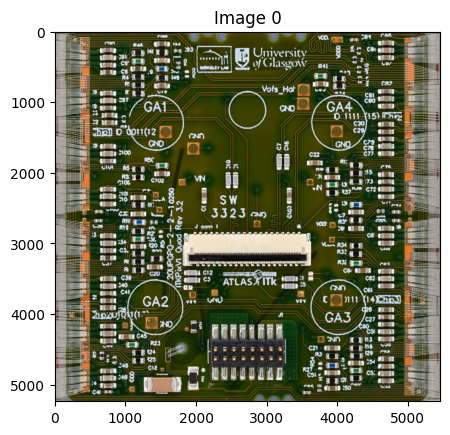

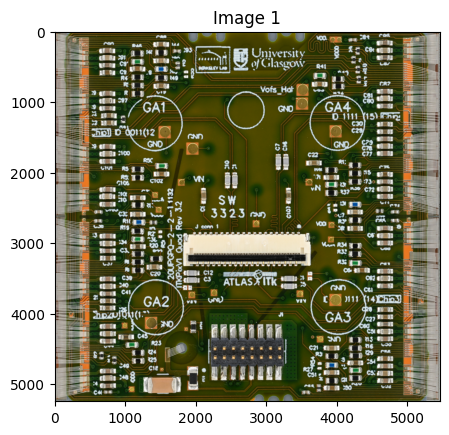

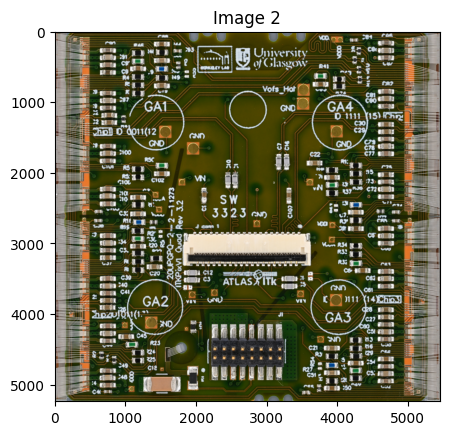

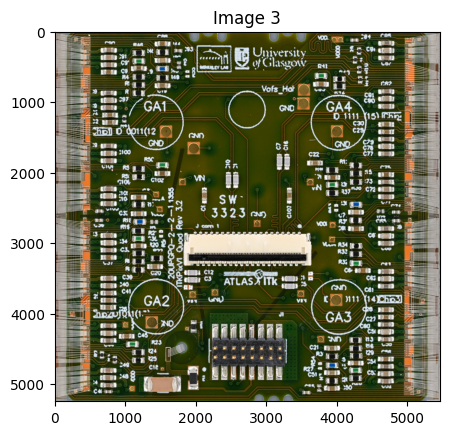

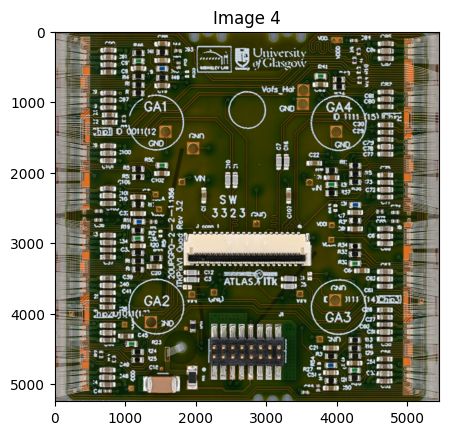

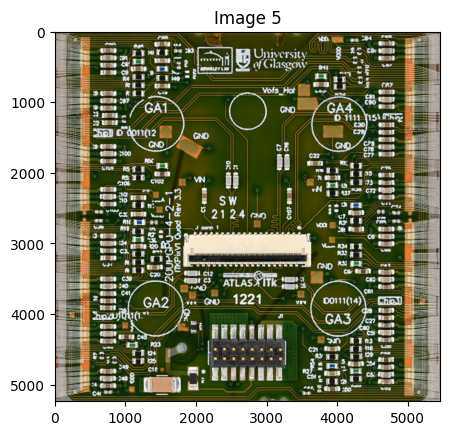

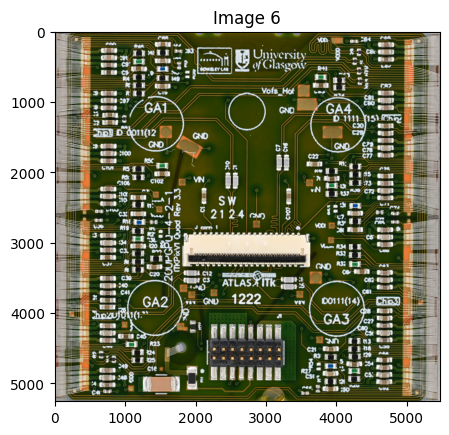

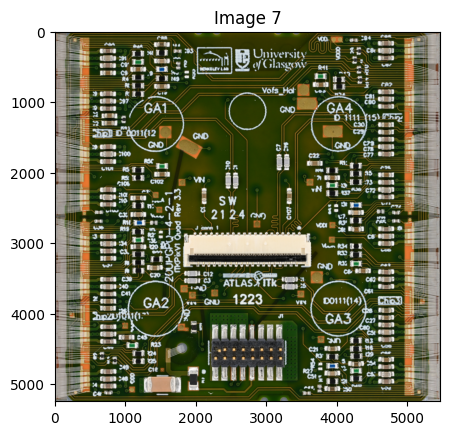

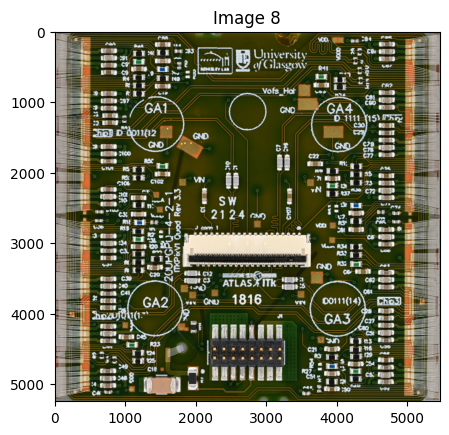

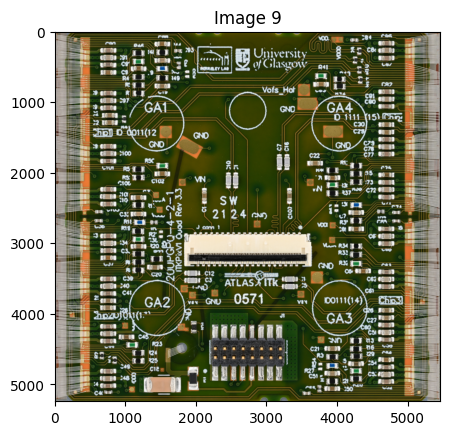

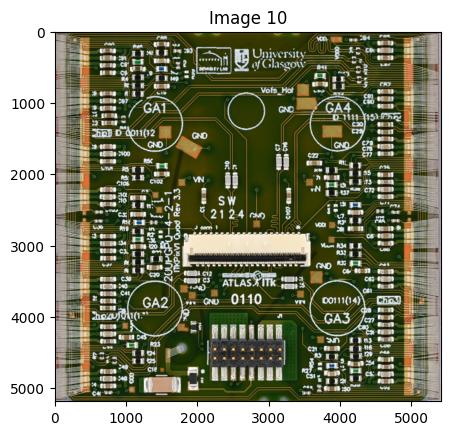

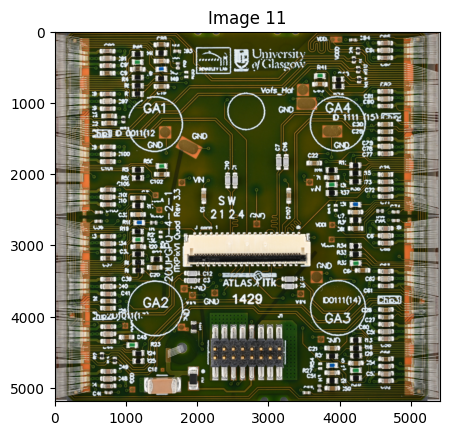

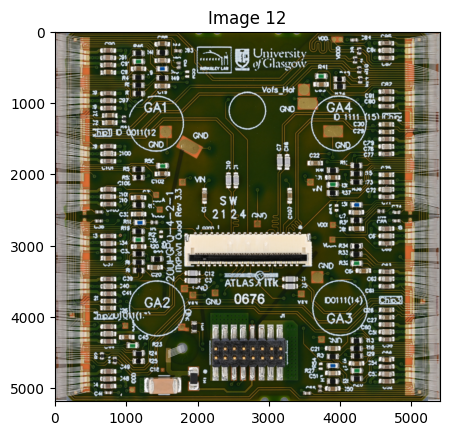

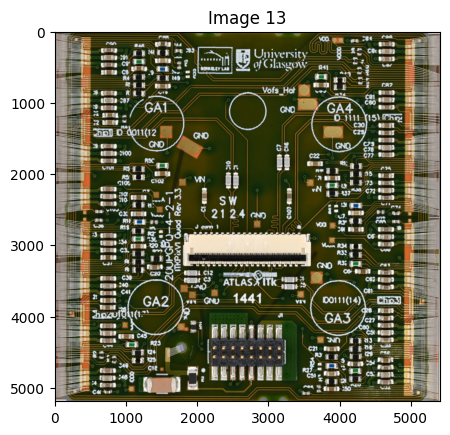

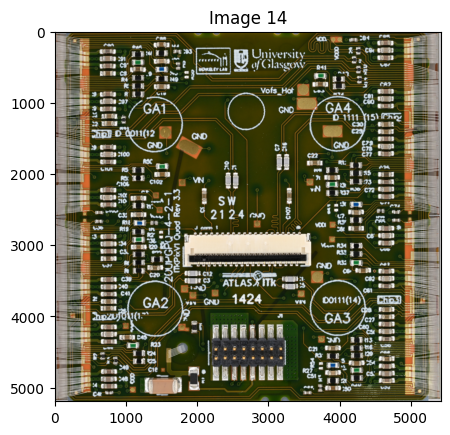

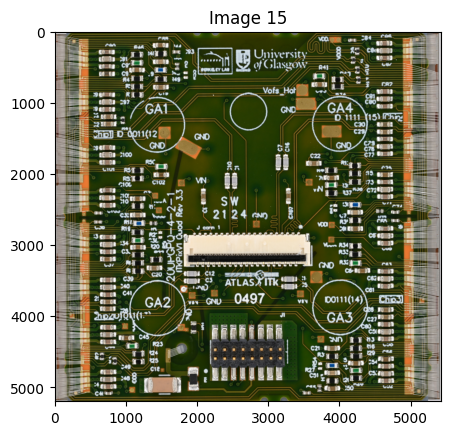

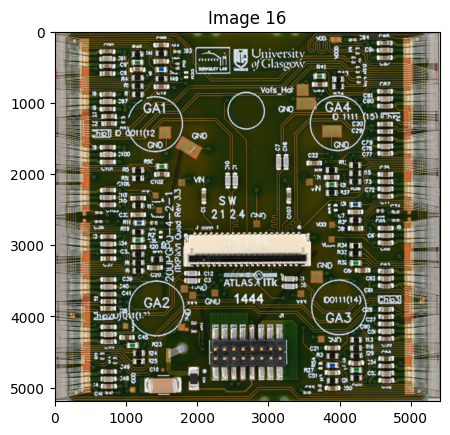

In [61]:
# Test 

for i,image in enumerate(liste_images_cablees):
    plt.imshow(croper(image))
    plt.title(f'Image {i}')
    plt.show()